#**DPhi - Deep Learning Bootcamp - Final Project:**
# **Gender Determination by Morphometry of Eyes**

---

---





# **Problem Statement**
The anthropometric analysis of the human face is an essential study for performing craniofacial plastic and reconstructive surgeries. Facial anthropometrics are affected by various factors such as age, gender, ethnicity, socioeconomic status, environment, and region.  

 

Plastic surgeons who undertake the repair and reconstruction of facial deformities find the anatomical dimensions of the facial structures useful for their surgeries. These dimensions are a result of the Physical or Facial appearance of an individual. Along with factors like culture, personality, ethnic background, age; eye appearance and symmetry contributes majorly to the facial appearance or aesthetics. 

 

Our objective is to **build a model to scan the image of an eye of a patient and find if the gender of the patient is male or female**.

# **Downloading the images**

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
dest_path='content/eye_gender_data.zip',
unzip=True)

Unzipping...Done.


# **Importing Libraries**

In [4]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# **Loading and preparing training data**

In [5]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv") # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
traindata = pd.merge(images, labels, how = 'inner', on = 'filename')


In [6]:
traindata.head()

,filename,filepaths,label
0,Image_1.jpg,/content/content/eye_gender_data/train/Image_1...,male
1,Image_2.jpg,/content/content/eye_gender_data/train/Image_2...,female
2,Image_3.jpg,/content/content/eye_gender_data/train/Image_3...,female
3,Image_4.jpg,/content/content/eye_gender_data/train/Image_4...,female
4,Image_5.jpg,/content/content/eye_gender_data/train/Image_5...,male


In [7]:
data = [] # initialize an empty numpy array
df=pd.DataFrame()
image_size = 64 # image size taken is 100 here. one can take other size too
for i in range(len(traindata)):
  img_array = cv2.imread(traindata['filepaths'][i]) # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
  data=pd.DataFrame({'image':[new_img_array],'label':traindata['label'][i]})
  df=df.append(data)
  i = i + 1


In [8]:
df.head()

,image,label
0,"[[[188, 188, 188], [189, 189, 189], [190, 190,...",male
0,"[[[130, 161, 194], [135, 166, 199], [143, 172,...",female
0,"[[[149, 166, 223], [145, 162, 219], [142, 160,...",female
0,"[[[34, 81, 155], [33, 80, 154], [32, 81, 155],...",female
0,"[[[177, 177, 177], [181, 181, 181], [173, 173,...",male


In [9]:
df['label'] = np.where(df['label']=='female', 1, 0)

In [10]:
df.head()

,image,label
0,"[[[188, 188, 188], [189, 189, 189], [190, 190,...",0
0,"[[[130, 161, 194], [135, 166, 199], [143, 172,...",1
0,"[[[149, 166, 223], [145, 162, 219], [142, 160,...",1
0,"[[[34, 81, 155], [33, 80, 154], [32, 81, 155],...",1
0,"[[[177, 177, 177], [181, 181, 181], [173, 173,...",0


In [11]:
df.shape

(9220, 2)

In [12]:
len(df), df.label.value_counts()

(9220, 0    5058
 1    4162
 Name: label, dtype: int64)

In [13]:
train_data,test_data=train_test_split(df,test_size=0.2,random_state=42)

In [14]:
print(f"Shape of Training data: {train_data.shape}")
print(f"shape of Test data: {test_data.shape}")

Shape of Training data: (7376, 2)
shape of Test data: (1844, 2)


In [15]:
train_data.label.value_counts(), test_data.label.value_counts()

(0    4029
 1    3347
 Name: label, dtype: int64, 0    1029
 1     815
 Name: label, dtype: int64)

In [16]:
train_data.head()

,image,label
0,"[[[123, 146, 202], [126, 149, 205], [126, 146,...",0
0,"[[[107, 149, 196], [103, 145, 191], [99, 141, ...",0
0,"[[[72, 93, 145], [74, 95, 147], [74, 93, 144],...",0
0,"[[[16, 21, 54], [26, 31, 64], [41, 46, 78], [5...",0
0,"[[[216, 216, 216], [221, 221, 221], [219, 219,...",1


# **Data Pre-processing**

In [17]:
def change_to_input_dimension(data):
    data=np.reshape(data.to_list(),(len(data),64,64,3))
    data=data/255.0
    return data
train_image=change_to_input_dimension(train_data.image)
test_image=change_to_input_dimension(test_data.image)

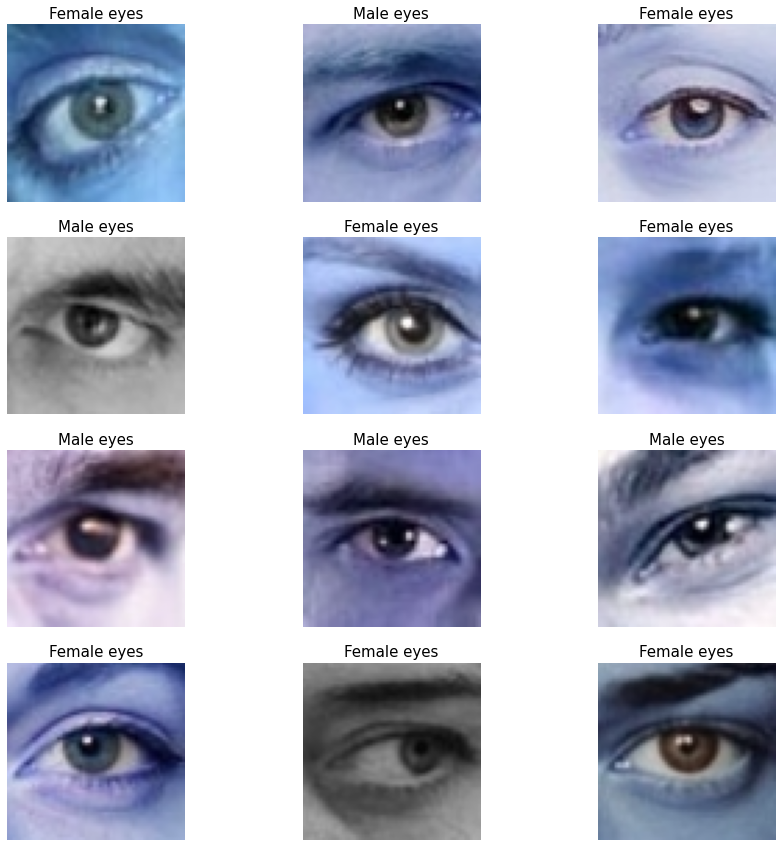

In [44]:
plt.figure(figsize=(15,15))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    rnd_idx=np.random.randint(1000)
    if train_data.label.values[rnd_idx]==1:
        plt.title('Female eyes',fontdict={'size':15})
    else:
        plt.title('Male eyes',fontdict={'size':15})
    
    plt.axis('off')
    plt.imshow(train_image[rnd_idx])

In [21]:
train_image.shape

(7376, 64, 64, 3)

# **Building Model & Hyperparameter tuning**

In [22]:
from keras.layers import BatchNormalization,Conv2D,MaxPool2D,Dense,Flatten,Input,GlobalMaxPooling2D,Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator


In [23]:
model=Sequential()
model.add(Input(shape=(64,64,3)))
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        2

In [26]:
early_stop=EarlyStopping(patience=4)
reduce_lr=ReduceLROnPlateau(patience=2)

# **Validate the model**

In [45]:
r=model.fit(train_image,train_data.label.values,validation_data=(test_image,test_data.label.values),
            epochs=20,
            callbacks=[early_stop,reduce_lr]
           )

Epoch 1/20
231/231 [==============================] - 160s 691ms/step - loss: 0.2964 - accuracy: 0.8810 - val_loss: 0.2879 - val_accuracy: 0.8785
Epoch 2/20
231/231 [==============================] - 158s 684ms/step - loss: 0.2567 - accuracy: 0.8976 - val_loss: 0.3832 - val_accuracy: 0.8357
Epoch 3/20
231/231 [==============================] - 157s 680ms/step - loss: 0.2310 - accuracy: 0.9085 - val_loss: 0.2310 - val_accuracy: 0.9035
Epoch 4/20
231/231 [==============================] - 157s 678ms/step - loss: 0.2121 - accuracy: 0.9155 - val_loss: 0.2463 - val_accuracy: 0.9051
Epoch 5/20
231/231 [==============================] - 156s 677ms/step - loss: 0.1835 - accuracy: 0.9272 - val_loss: 0.2178 - val_accuracy: 0.9181
Epoch 6/20
231/231 [==============================] - 156s 676ms/step - loss: 0.1715 - accuracy: 0.9344 - val_loss: 0.2283 - val_accuracy: 0.9111
Epoch 7/20
231/231 [==============================] - 156s 676ms/step - loss: 0.1663 - accuracy: 0.9338 - val_loss: 0.2784 -

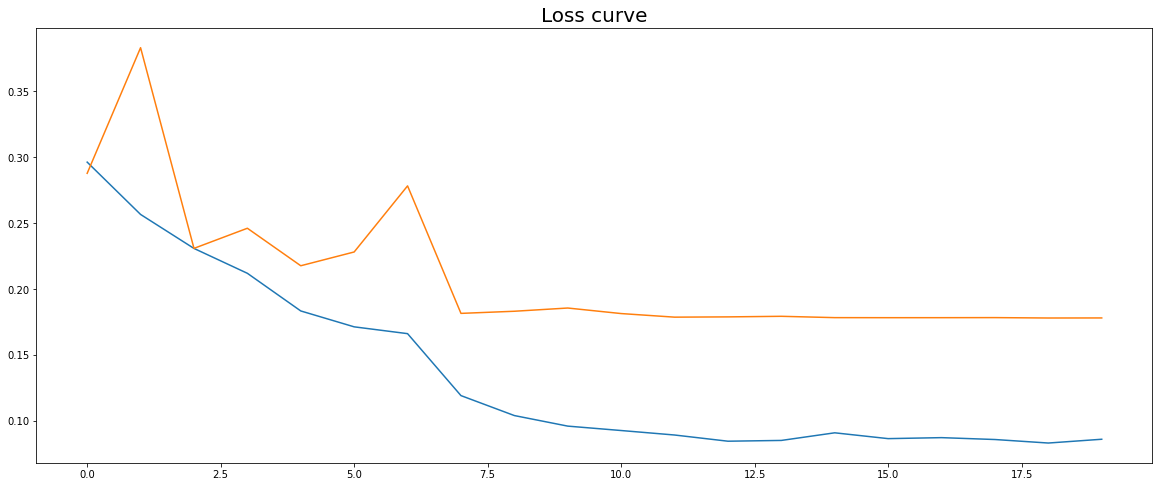

In [49]:
plt.figure(figsize=(20,8))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Loss curve',fontdict={'size':20})
plt.show()

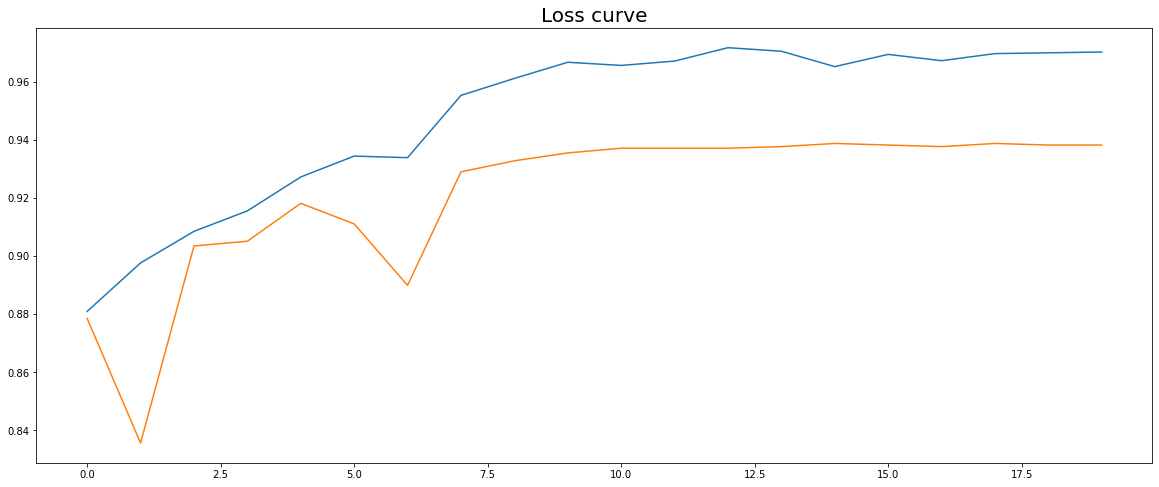

In [50]:
plt.figure(figsize=(20,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Loss curve',fontdict={'size':20})
plt.show()

In [48]:
print('CLASSIFICATION REPORT ON TRAIN DATASET \n\n')
print(classification_report(train_data.label,model.predict_classes(train_image),target_names=['male','female']))

print('CLASSIFICATION REPORT ON TEST DATASET \n\n')
print(classification_report(test_data.label,model.predict_classes(test_image),target_names=['male','female']))

CLASSIFICATION REPORT ON TRAIN DATASET 




/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        male       0.98      0.99      0.98      4029
      female       0.99      0.97      0.98      3347

    accuracy                           0.98      7376
   macro avg       0.98      0.98      0.98      7376
weighted avg       0.98      0.98      0.98      7376

CLASSIFICATION REPORT ON TEST DATASET 


              precision    recall  f1-score   support

        male       0.94      0.95      0.94      1029
      female       0.94      0.92      0.93       815

    accuracy                           0.94      1844
   macro avg       0.94      0.94      0.94      1844
weighted avg       0.94      0.94      0.94      1844



# **Prediction**

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


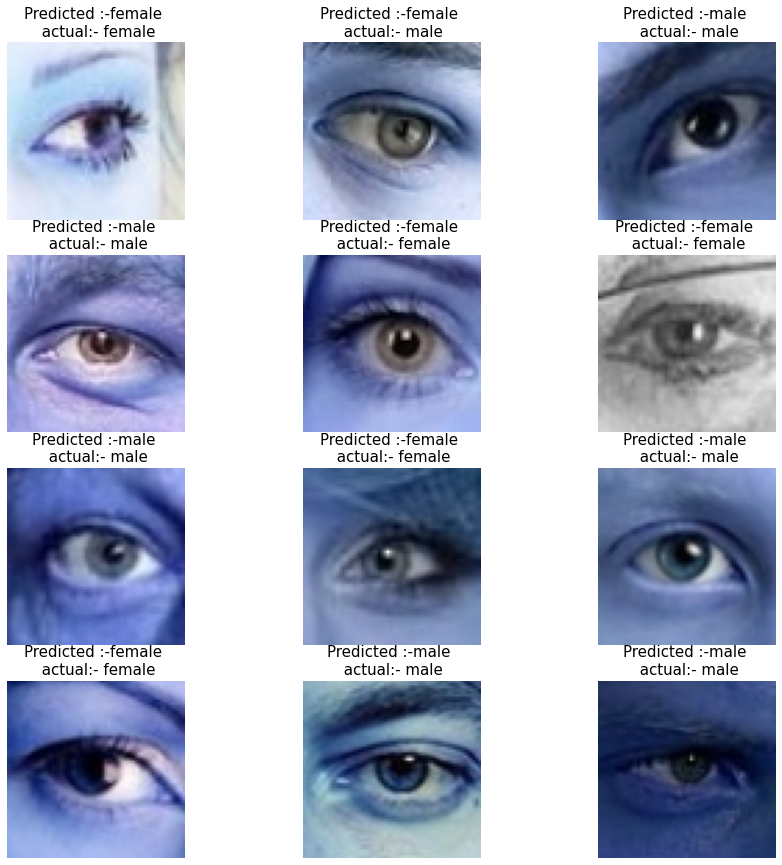

In [53]:
plt.figure(figsize=(15,15))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    rnd_idx=np.random.randint(1000)
    pred=model.predict_classes(test_image[rnd_idx:rnd_idx+1])
    if test_data.label.values[rnd_idx]==1:
        if pred==1:
            plt.title('Predicted :-female \n actual:- female',fontdict={'size':15})
        else:
            plt.title('Predicted :-male \n actual:- female',fontdict={'size':15})
    else:
        if pred==1:
            plt.title('Predicted :-female \n actual:- male',fontdict={'size':15})
        else:
            plt.title('Predicted :-male \n actual:- male',fontdict={'size':15})
    
    plt.axis('off')
    plt.imshow(test_image[rnd_idx])

In [54]:
labels = pd.read_csv("/content/content/eye_gender_data/Testing_set.csv") # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/test/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
testdata = pd.merge(images, labels, how = 'inner', on = 'filename')


In [61]:
data = [] # initialize an empty numpy array
df=pd.DataFrame()
image_size = 64 # image size taken is 100 here. one can take other size too
for i in range(len(testdata)):
  img_array = cv2.imread(testdata['filepaths'][i]) # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
  data=pd.DataFrame({'image':[new_img_array],'filename':images['filename'][i]})
  df=df.append(data)

In [65]:
df.head()

,image,filename
0,"[[[110, 130, 171], [112, 132, 173], [114, 131,...",Image_1.jpg
0,"[[[110, 153, 210], [117, 160, 217], [123, 163,...",Image_2.jpg
0,"[[[164, 194, 251], [160, 190, 247], [157, 187,...",Image_3.jpg
0,"[[[36, 47, 45], [32, 43, 41], [29, 39, 39], [2...",Image_4.jpg
0,"[[[160, 195, 245], [162, 197, 247], [166, 199,...",Image_5.jpg


In [66]:
testdataimage=change_to_input_dimension(df.image)

In [67]:
predictions = model.predict(testdataimage)
pred = predictions
pred = [row[0] for row in predictions]

In [68]:
for idx, item in enumerate(pred):
  if (item>=0.5):
    pred[idx] = 'female'
  else:
    pred[idx] = 'male'

# **Saving prediction results**

In [69]:
res = pd.DataFrame({'filename': df['filename'].to_list(), 'label': pred}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---



---

